In [1]:

from pathlib import Path
import argparse
import json
import math
import os
import sys
import time

import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.distributed as dist
import torchvision.datasets as datasets

import augmentations_fmow as aug
from distributed import init_distributed_mode

import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json

import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

import resnet

import torchvision

from fmow_dataloader import CustomDatasetFromImages, CustomDatasetFromImagesTemporal

train_csv = "./fmow/csv_file.csv"

In [2]:
transforms = aug.TrainTransform()
#transforms = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
dataset = CustomDatasetFromImagesTemporal(train_csv,transform=transforms)

#dataset = datasets.ImageFolder(args.data_dir / "train", transforms)
loader = DataLoader(dataset=dataset, batch_size = 5, num_workers=10,  sampler = None)     #sampler=sampler)

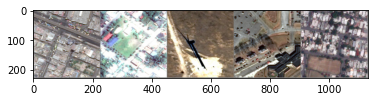

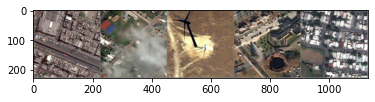

<Figure size 432x288 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt


def imshow(img, count):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.savefig('temporal_plot'+str(count))

    
dataiter = iter(loader)
images, images_2 = dataiter.next()
#print(torch.sum(torch.isnan(images)))
#print(torch.sum(torch.isinf(images)))
#print(torch.unique(images))
#print(labels)

# show images
count = 0
imshow(torchvision.utils.make_grid(images),count)
count = 1
imshow(torchvision.utils.make_grid(images_2),count)

In [4]:
dataset.__getitem__(34665)

['/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_2_rgb.jpg', '/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_5_rgb.jpg', '/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_12_rgb.jpg', '/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_11_rgb.jpg', '/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_13_rgb.jpg', '/local/home/bsoyuer/citiies_contrastive_learning/vicreg_pure/vicreg/fmow/train/recreational_facility/recreational_facility_642/recreational_facility_642_1_rgb.jpg', 

(tensor([[[-1.6727, -1.3815, -1.2445,  ..., -0.2171, -0.5082, -0.8507],
          [-1.3130, -1.2959, -1.0733,  ...,  0.3309,  0.0398, -0.3198],
          [-1.2274, -1.1932, -0.5596,  ...,  0.4851,  0.3652,  0.1939],
          ...,
          [-0.2513, -0.1486, -0.2513,  ..., -0.1143, -0.0801, -0.0458],
          [-0.0972, -0.1314, -0.1486,  ..., -0.1486, -0.1486, -0.1486],
          [-0.0972, -0.0972, -0.1314,  ..., -0.2171, -0.1486, -0.1486]],
 
         [[-1.4580, -1.1954, -1.0378,  ..., -0.0574, -0.3375, -0.6527],
          [-1.1078, -1.1078, -0.8978,  ...,  0.4678,  0.2052, -0.1625],
          [-1.0378, -1.0028, -0.3901,  ...,  0.6254,  0.5378,  0.3627],
          ...,
          [-0.0749, -0.0049, -0.0749,  ...,  0.0301,  0.0651,  0.1001],
          [ 0.0826,  0.0301,  0.0126,  ..., -0.0049, -0.0224, -0.0049],
          [ 0.0651,  0.0476,  0.0301,  ..., -0.0924, -0.0049, -0.0049]],
 
         [[-1.0898, -0.7761, -0.5495,  ...,  0.4091,  0.1476, -0.1661],
          [-0.7064, -0.6193,